# Telco Customer Churn Prediction
### Summer Internship Project – Codec Technologies

---

## Project Objective
The goal of this project is to predict which telecom customers are likely to churn (cancel their subscription).  
In this context, churn means that a customer has discontinued their service (internet, phone, or bundle) with the company.  
By identifying at-risk customers, the company can implement retention strategies to reduce churn and maintain revenue.

## Step 1: Import Libraries
We will import the necessary Python libraries for data manipulation, visualization, and machine learning.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import joblib

## Step 2: Load and Clean the Dataset
We will load the Telco Customer Churn dataset and perform initial cleaning to make it ready for modeling:
- Remove the `customerID` column (it does not provide predictive value).
- Convert the `TotalCharges` column to numeric (some values are stored as strings due to blanks).
- Drop rows with missing `TotalCharges` values.
- Encode the target variable `Churn` as 0 (No) and 1 (Yes).
for maintaining class balance.

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")

In [3]:
df.drop("customerID", axis = 1, inplace = True)

In [4]:
blank_col = df.columns[(df.astype(str).apply(lambda x : x.str.strip()) == "").any()]
print(blank_col)

Index(['TotalCharges'], dtype='object')


In [5]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = "coerce")

In [6]:
missing_count = df["TotalCharges"].isna().sum()
print(missing_count)

11


In [7]:
# Since there were only 11 missing values out of 7043 rows (0.15%), 
# we safely dropped those rows without significantly impacting the dataset.

df = df.dropna(subset = ["TotalCharges"])

In [8]:
df = df.reset_index(drop=True)

In [9]:
mapping = {
    "Yes" : 1,
    "No" : 0
}
df["Churn"] = df["Churn"].map(mapping)

## Step 3: Split Data into Train and Test Sets
We will split the dataset into training and testing sets while preserving the proportion of churned and non-churned customers.  
This ensures that both sets have a representative distribution of the target variable, which is important for training and evaluating our models accurately.  

We will use a **stratified split** to maintain the same ratio of churn in both sets.

In [10]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(df, df["Churn"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

## Step 4: Basic Exploratory Data Analysis (EDA)
Before building models, we perform a quick exploratory analysis to understand the dataset and observe any patterns related to customer churn.

**EDA Steps:**
1. **Basic Info**: Check data types, non-null counts, and summary statistics for numeric columns.
2. **Target Distribution**: Examine the distribution of the `Churn` variable (counts and proportions).
3. **Feature Exploration**:
   - **Numeric features**: Visualize distributions using histograms (`tenure`, `MonthlyCharges`, `TotalCharges`).
   - **Categorical features**: Visualize the most relevant categories using bar plots (`Contract`, `PaymentMethod`, `InternetService`, `OnlineSecurity`, `TechSupport`) .
4. **Correlation Analysis**: Compute correlation among numeric features and visualize using a heatmap to identify potential relationships with churn.
5. **Insights**: Summarize key observations and patterns that could inform modeling.


In [11]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5625 entries, 1408 to 1500
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5625 non-null   object 
 1   SeniorCitizen     5625 non-null   int64  
 2   Partner           5625 non-null   object 
 3   Dependents        5625 non-null   object 
 4   tenure            5625 non-null   int64  
 5   PhoneService      5625 non-null   object 
 6   MultipleLines     5625 non-null   object 
 7   InternetService   5625 non-null   object 
 8   OnlineSecurity    5625 non-null   object 
 9   OnlineBackup      5625 non-null   object 
 10  DeviceProtection  5625 non-null   object 
 11  TechSupport       5625 non-null   object 
 12  StreamingTV       5625 non-null   object 
 13  StreamingMovies   5625 non-null   object 
 14  Contract          5625 non-null   object 
 15  PaperlessBilling  5625 non-null   object 
 16  PaymentMethod     5625 non-null   object 
 1

In [12]:
strat_train_set.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,5625.000000,5625.000000,5625.000000,5625.000000,5625.000000
mean,0.161778,32.562311,64.999316,2301.839520,0.265778
std,0.368280,24.542421,30.108642,2275.586084,0.441786
min,0.000000,1.000000,18.400000,18.800000,0.000000
25%,0.000000,9.000000,35.800000,413.000000,0.000000
50%,0.000000,29.000000,70.600000,1410.250000,0.000000
75%,0.000000,56.000000,90.050000,3801.700000,1.000000
max,1.000000,72.000000,118.650000,8684.800000,1.000000


In [13]:
strat_train_set['Churn'].value_counts()

Churn
0    4130
1    1495
Name: count, dtype: int64

In [14]:
strat_train_set['Churn'].value_counts(normalize=True)

Churn
0    0.734222
1    0.265778
Name: proportion, dtype: float64

### Numeric Features
Visualizing distributions of numeric features: `tenure`, `MonthlyCharges`, `TotalCharges`.

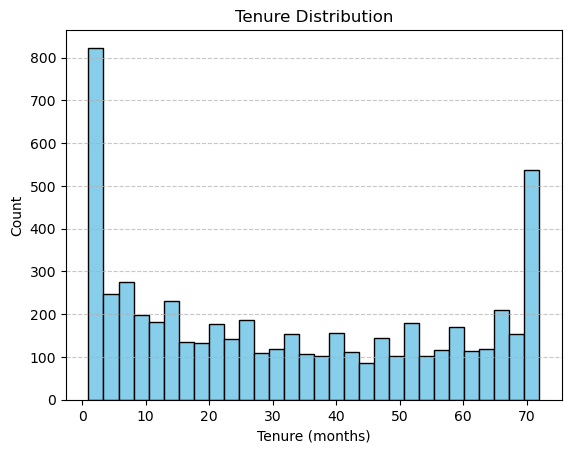

In [15]:
# Tenure
plt.hist(strat_train_set['tenure'], bins=30, edgecolor='black', color='skyblue')
plt.title("Tenure Distribution")
plt.xlabel("Tenure (months)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

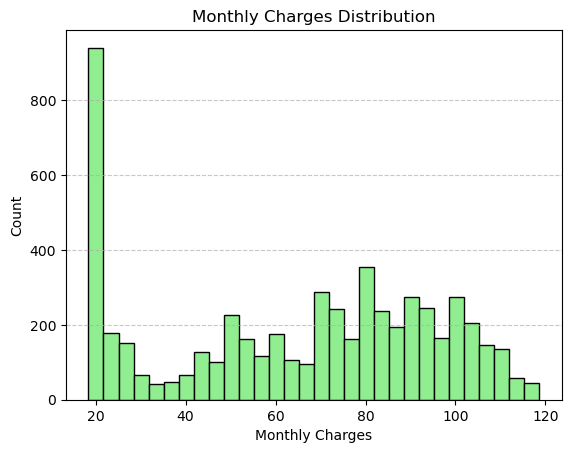

In [16]:
# Monthly Charges
plt.hist(strat_train_set['MonthlyCharges'], bins=30, edgecolor='black', color='lightgreen')
plt.title("Monthly Charges Distribution")
plt.xlabel("Monthly Charges")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

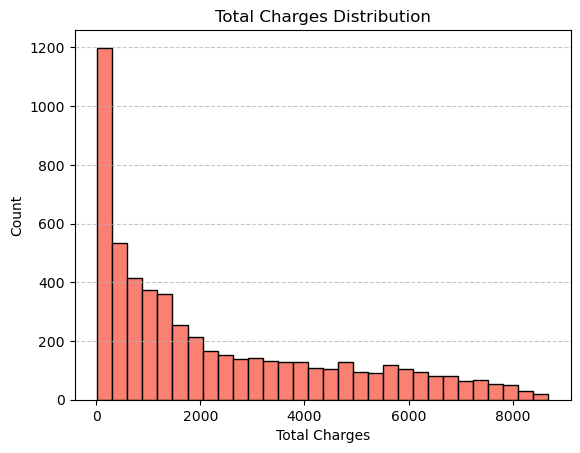

In [17]:
# Total Charges
plt.hist(strat_train_set['TotalCharges'], bins=30, edgecolor='black', color='salmon')
plt.title("Total Charges Distribution")
plt.xlabel("Total Charges")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Categorical Features
Visualizing counts of key categorical features: `Contract`, `PaymentMethod`, `InternetService`, `OnlineSecurity`, `TechSupport`.

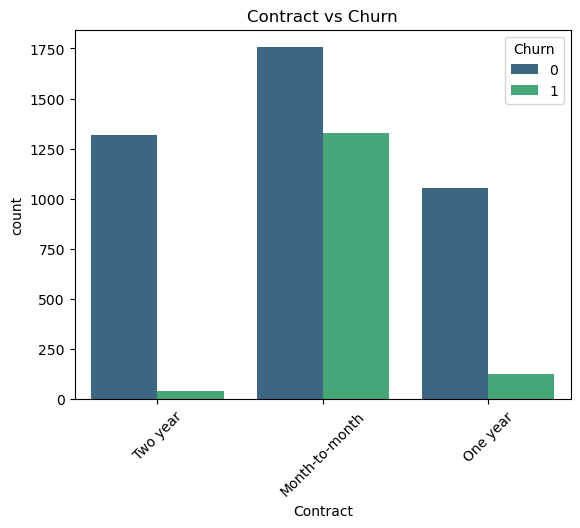

In [18]:
# Contract
sns.countplot(data = strat_train_set, x='Contract', hue='Churn', palette='viridis')
plt.title("Contract vs Churn")
plt.xticks(rotation=45)
plt.show()

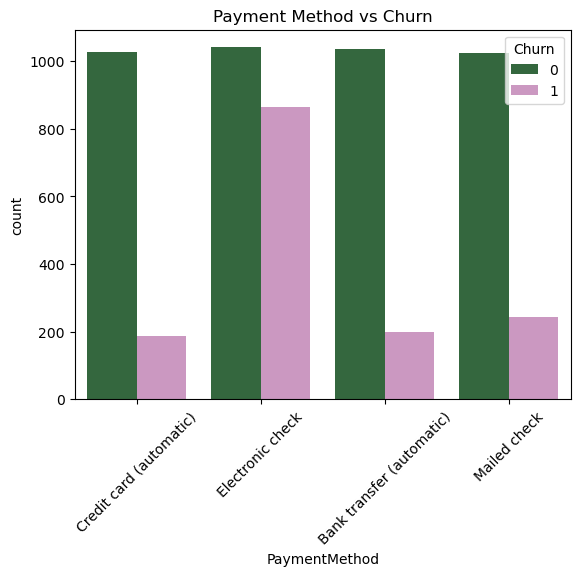

In [19]:
# Payment Method
sns.countplot(data=strat_train_set, x='PaymentMethod', hue='Churn', palette='cubehelix')
plt.title("Payment Method vs Churn")
plt.xticks(rotation=45)
plt.show()

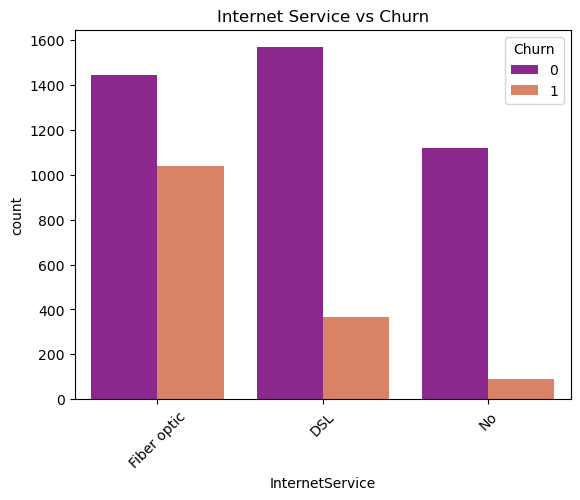

In [20]:
# Internet Service
sns.countplot(data=strat_train_set, x='InternetService', hue='Churn', palette='plasma')
plt.title("Internet Service vs Churn")
plt.xticks(rotation=45)
plt.show()

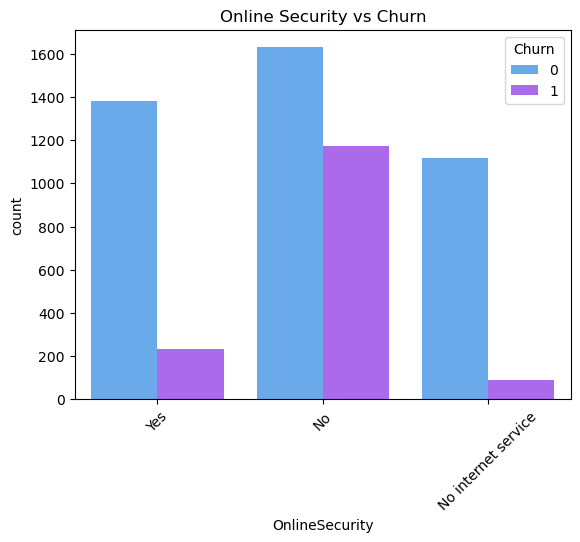

In [21]:
# Online Security
sns.countplot(data=strat_train_set, x='OnlineSecurity', hue='Churn', palette='cool')
plt.title("Online Security vs Churn")
plt.xticks(rotation=45)
plt.show()

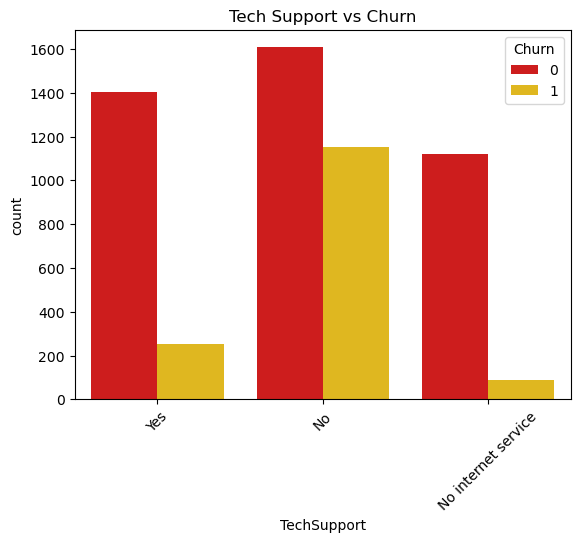

In [22]:
# Tech Support
sns.countplot(data=strat_train_set, x='TechSupport', hue='Churn', palette='hot')
plt.title("Tech Support vs Churn")
plt.xticks(rotation=45)
plt.show()

In [23]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']
corr_matrix = strat_train_set[numeric_features].corr()

print(corr_matrix)

                  tenure  MonthlyCharges  TotalCharges     Churn
tenure          1.000000        0.250410      0.827181 -0.351710
MonthlyCharges  0.250410        1.000000      0.652554  0.193455
TotalCharges    0.827181        0.652554      1.000000 -0.197988
Churn          -0.351710        0.193455     -0.197988  1.000000


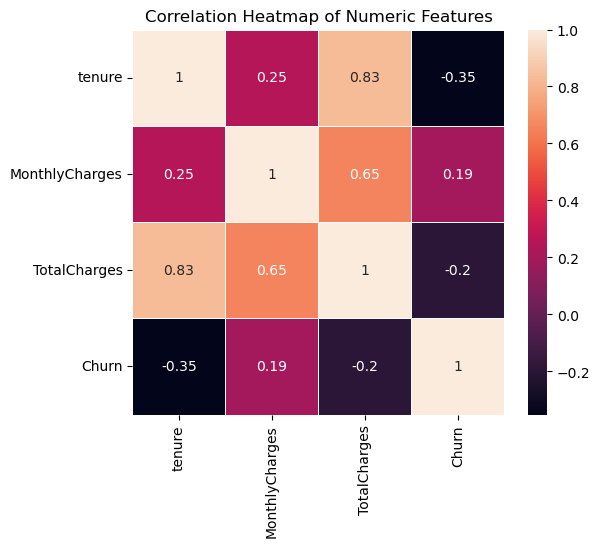

In [24]:
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### Insights from EDA

**1. Churn Distribution**  
- About 26% of customers churned, while 74% stayed.  
- Most customers are retained, but a noticeable minority leave, making churn prediction important.

**2. Numeric Features**  
- **Tenure:** Longer-tenured customers are less likely to churn (negative correlation: -0.35).  
- **TotalCharges:** Highly correlated with tenure (0.83), reflecting that long-term customers accumulate higher total charges.  

**3. Categorical Features**  
- **Contract Type:** Customers on short-term or month-to-month contracts are more prone to churn compared to long-term contracts.  
- **Payment Method:** Customers using manual payment methods (e.g., mailed checks) are slightly more likely to churn.  
- **Internet Service & Added Services:** Customers without services like Online Security or Tech Support show slightly higher churn rates.  

**4. Overall Observations**  
- Longer tenure and consistent service usage reduce churn risk.  
- Contract type, payment method, and availability of service add-ons appear to influence churn patterns.  

## Step 5: Preprocessing & Encoding

Before building machine learning models, we need to prepare the data:

- **Separate features and target:**  
  - `X` contains all features except `Churn`.  
  - `y` contains the target variable `Churn`.

- **Identify feature types:**  
  - **Numeric features:** `SeniorCitizen`, `tenure`, `MonthlyCharges`, `TotalCharges`.  
  - **Categorical features:** all string/object columns such as `gender`, `Partner`, `Contract`, etc.

- **Define transformations:**  
  - Numeric features → scaled using `StandardScaler`.  
  - Categorical features → one-hot encoded using `OneHotEncoder`.

- **Combine using `ColumnTransformer`:**  
  - Applies the correct transformation to each type of column.  
  - Prepares the dataset for any machine learning model in a pipeline.

In [25]:
X = strat_train_set.drop("Churn", axis=1)
y = strat_train_set["Churn"]

In [26]:
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]

categorical_features = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines",
    "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies", "Contract",
    "PaperlessBilling", "PaymentMethod"
]

In [27]:
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown = "ignore"))
])

In [28]:
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

## Step 6: Build Machine Learning Pipelines

Now that the data is preprocessed, we will create pipelines that combine preprocessing with a machine learning model.  

- **Purpose of Pipeline:** Ensures that all transformations (scaling, encoding) are applied consistently to both training and test data.  
- **Model Choice:** We will start with Logistic Regression as our baseline model. Later, we can try other models like Random Forest and Gradient Boosting.  
- **Pipeline Structure:**  
  1. Preprocessing using the `ColumnTransformer` from Step 5.  
  2. Model (e.g., Logistic Regression) for prediction.  

Once the pipeline is built, we can train it on the training dataset and evaluate its performance on the test set.

In [29]:
# 1. Logistic Regression pipeline
logreg_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

In [30]:
# 2. Random Forest pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100))
])

In [31]:
# 3. Gradient Boosting pipeline
gb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(n_estimators=100))
])

In [32]:
logreg_pipeline.fit(X, y)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [33]:
rf_pipeline.fit(X, y)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
gb_pipeline.fit(X, y)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [35]:
logreg_cv_scores = cross_val_score(logreg_pipeline, X, y, cv=5, scoring="roc_auc")

print("Logistic Regression CV ROC-AUC mean :", logreg_cv_scores.mean())

Logistic Regression CV ROC-AUC mean : 0.8459194085207351


In [36]:
rf_cv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring="roc_auc")

print("Random Forext CV ROC-AUC mean :", rf_cv_scores.mean())

Random Forext CV ROC-AUC mean : 0.8182237806408773


In [37]:
gb_cv_scores = cross_val_score(gb_pipeline, X, y, cv=5, scoring="roc_auc")

print("Gradient Boosting CV ROC-AUC mean :", gb_cv_scores.mean())

Gradient Boosting CV ROC-AUC mean : 0.8457096698437893


### Step 7: Hyperparameter Tuning

After evaluating baseline models using cross-validation, we select the best-performing models for hyperparameter tuning to optimize their performance.

**Why?**
- Default hyperparameters may not provide the best possible model performance.
- Tuning helps improve ROC-AUC, accuracy, and recall by exploring multiple parameter combinations.

**Approach:**
1. Use **GridSearchCV** to perform exhaustive search over a specified parameter grid.
2. Integrate tuning inside the existing **pipeline** so that preprocessing and modeling happen together.
3. Optimize for **ROC-AUC** because it's a better metric for imbalanced churn prediction than raw accuracy.

**Steps:**
- Define parameter grids for:
    - **Logistic Regression:** `C` (regularization strength), `solver`, `max_iter`.
    - **Gradient Boosting:** `n_estimators`, `learning_rate`, `max_depth`.
- Fit `GridSearchCV` on training data.
- Retrieve:
    - Best parameters
    - Best score
    - Best estimator


In [38]:
logreg_param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__solver": ["lbfgs", "liblinear"],
    "classifier__max_iter": [100, 200, 500]
}

logreg_grid = GridSearchCV(estimator = logreg_pipeline, param_grid = logreg_param_grid, scoring = "roc_auc", 
                           cv = 5, n_jobs = -1)

logreg_grid.fit(X, y)

print("Best Logistic Regression Params:", logreg_grid.best_params_)
print("Best Logistic Regression ROC-AUC:", logreg_grid.best_score_)

Best Logistic Regression Params: {'classifier__C': 10, 'classifier__max_iter': 100, 'classifier__solver': 'lbfgs'}
Best Logistic Regression ROC-AUC: 0.8462044587689392


In [39]:
gb_param_grid = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__max_depth": [3, 4, 5]
}

gb_grid = GridSearchCV(estimator = gb_pipeline, param_grid = gb_param_grid, scoring = "roc_auc", cv = 5, n_jobs = -1)

gb_grid.fit(X, y)

print("Best Gradient Boosting Params:", gb_grid.best_params_)
print("Best Gradient Boosting ROC-AUC:", gb_grid.best_score_)

Best Gradient Boosting Params: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 50}
Best Gradient Boosting ROC-AUC: 0.8476232315952286


## Step 8: Final Model Evaluation

After hyperparameter tuning, we select the best-performing model and evaluate its performance on the test set. This ensures that the model generalizes well to unseen data.

**Steps:**

1. Select the final model based on ROC-AUC or other relevant metrics from cross-validation and GridSearchCV.
2. Fit the model on the full training set.
3. Evaluate on the test set using:
   - ROC-AUC score
   - Confusion matrix
   - Classification report (accuracy, precision, recall, F1-score)

**Purpose:**  
- Validate the model on unseen data to estimate real-world performance.

In [40]:
best_params = {
    "n_estimators": 50,
    "learning_rate": 0.1,
    "max_depth": 3
}

final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(**best_params))
])

final_pipeline.fit(X, y)

X_test = strat_test_set.drop("Churn", axis=1)
y_test = strat_test_set["Churn"]

y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

ROC-AUC Score: 0.8392214669903868
Confusion Matrix:
 [[921 112]
 [179 195]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



We trained the Gradient Boosting Classifier with optimized hyperparameters on the full training set and evaluated it on the test set.

**Key Results:**

* **ROC-AUC Score:** 0.839 → good overall discrimination between churn and non-churn.
* **Accuracy:** 79%
* **Churn Prediction:** Precision = 0.64, Recall = 0.52, F1-score = 0.57 → model is better at predicting non-churn than churn.

## Step 9: Save the Trained Model

After training and evaluating our final Gradient Boosting pipeline, we save it to a file using `joblib`.  
This allows us to reuse the trained model later for making predictions on new data without retraining.  
Saving the **entire pipeline** ensures that all preprocessing steps (scaling, encoding) are preserved along with the model.

In [41]:
PIPELINE_FILE = "telco_churn_pipeline.pkl"

joblib.dump(final_pipeline, PIPELINE_FILE)

['telco_churn_pipeline.pkl']